In [1]:
import glob
import json
import pandas as pd
import numpy as np

In [2]:
def load_result(name, pattern, num_seeds):
  
  metrics = [
    'all_run_consistency',
    'train_run_consistency',
    'valid_run_consistency',
    'test_run_consistency',
    'all', 'train', 'valid', 'test', 'knn',
    'valid_total_r2', 'valid_position_error', 'valid_position_r2',
    'test_total_r2', 'test_position_error', 'test_position_r2',
    'test_total_r2_svm', 'test_position_error_svm', 'test_position_r2_svm'
  ]

  def _load_dfs(pattern):
    dfs = []
    for fname in sorted(glob.glob(pattern)):
      with open(fname, "r") as fh:
        data = list(map(json.loads, filter(len, fh.read().split("\n"))))
      df = pd.DataFrame(data)
      dfs.append(df.drop(columns = "group_by"))
    assert len(dfs) == 2, pattern
    return dfs
  
  def _parse_shape(shape):
    if len(shape) == 1:
      return 1, shape[0]
    elif len(shape) == 2:
      return shape
    raise ValueError(shape)

  by_animal, by_seed = _load_dfs(pattern)
  shape, = by_animal.train_run_consistency.apply(lambda v : np.array(v).shape).unique()
  num_animals, cfm_size = _parse_shape(shape)
  
  params = list(set(by_animal.columns).difference(metrics))
  
  #TODO
  if num_animals == 1:
    by_animal["animal"] = np.tile(np.arange(0,4), len(by_animal) // 4)
    params_wo_animal = list(set(params).difference({"animal"}))
    by_animal = by_animal.groupby(params_wo_animal).agg(list).reset_index()
    num_animals = 4
  
  #return by_animal, by_seed
  cfm_size_animals = by_seed.valid.apply(len).unique()
  assert cfm_size == num_seeds * (num_seeds - 1)
  assert cfm_size_animals == 4 * (4 - 1)

  def add_values(key, num):
    def _add_values(df):
      df[key] = np.arange(num)
      return df
    return _add_values

  # expand the values in the results that were collected for each repeat
  # of the experiment. For the consistency metrics, we get vectors of shape (12,)
  # and of shape (4,) for decoding metrics. The seed is represented as a non-unique
  # index.
  by_seed = by_seed.groupby(params).apply(add_values("seed", num_seeds))
  metric_names = list(set(by_seed.columns).intersection(metrics))
  c_metrics = ["train", "valid", "test", "all"]
  for m in c_metrics:
    if m in by_seed.columns:
      by_seed[m] = by_seed[m].apply(lambda v : np.array(v).reshape(4,3))
  by_seed = by_seed\
  .explode(metric_names)\
  .groupby(params + ['seed'])\
  .apply(add_values("animal", 4))

  # expand the values in the results that were collected for each animal, across
  # repeats of the experiment. We get vectors of shape (4, N(N-1),) depending on the
  # number N of seeds.
  metric_names = list(set(by_animal.columns).intersection(metrics))
  for key in metric_names:
    by_animal[key] = by_animal[key].apply(lambda v : np.array(v).reshape(4, num_seeds, num_seeds-1).tolist())
  by_animal = by_animal\
  .explode(metric_names)\
  .groupby(params)\
  .apply(add_values("animal", 4))\
  .explode(metric_names)\
  .groupby(params + ['animal'])\
  .apply(add_values("seed", num_seeds))

  assert len(by_seed) == len(by_animal)
  
  by_seed_indexed = by_seed.set_index(["animal", "seed"] + params)
  by_animal_indexed = by_animal.set_index(["animal", "seed"] + params)
  aggregated = pd.concat([
    by_seed_indexed,
    by_animal_indexed
  ], axis = 1)
  aggregated.columns.name = name
  return aggregated

In [66]:
import joblib

def _load(*args, **kwargs):
  try:
    return load_result(*args, **kwargs)
  except Exception as e:
    print("[FAIL]", args, kwargs)
    raise e

root = '/home/stes/ssh/cebra_public/results'

In [67]:
results = {
  key : _load(key, fname, num_seeds = num_seeds)
  for key, fname, num_seeds in [
      #("cebra-b-defaults", f"{root}/figure2_update_v3/cebra-behaviour-defaults_*.json", 10),  
      ("cebra-b-sweep", f"{root}/figure2_update_v4/figure2-cebra-behavior-sweep-grid-2_*.json", 3),  
      #("cebra-b-rat0", f"{root}/figure2_update_v5/cebra-behavior_*.json", 10),
      ("cebra-b", f"{root}/figure2_update_v5/cebra-behavior-allrats*.json", 10),
      ("cebra-b-s1", f"{root}/figure2_update_v5/cebra-behavior-step1-sweep*.json", 3),
      ("pivae-w", f"{root}/figure2_update_v5/pivae-with-labels_*.json", 10),
      #("cebra-t-defaults", f"{root}/ /cebra-time-defaults_*.json", 10),
      ("cebra-t-sweep", f"{root}/figure2_update_v4/figure2-cebra-time-sweep-grid-2_*.json", 3),
      #("cebra-t-rat0", f"{root}/figure2_update_v5/cebra-time_*.json", 10),
      #("cebra-t-lowertemp", f"{root}/figure2_update_v5/cebra-time-lowertemp*.json", 10),
      ("cebra-t", f"{root}/figure2_update_v5/cebra-time-allrats*.json", 10),
      ("cebra-t-s1", f"{root}/figure2_update_v5/cebra-time-step1-sweep*.json", 3),
      ("pivae-wo", f"{root}/figure2_update_v3/pivae-without-labels_*.json", 10),
      #("tsne", f"{root}/figure2_update_v3/tsne*grid-v2*.json", 3),
      #("tsne-rat0", f"{root}/figure2_update_v5/tsne_*", 10),
      ("tsne", f"{root}/figure2_update_v5/tsne-allrats*", 10),
      #("umap", f"{root}/figure2_update_v3/umap*grid-v2*.json", 3), 
      #("umap-rat0", f"{root}/figure2_update_v5/umap_*", 10),  
      ("umap", f"{root}/figure2_update_v5/umap-allrats*", 10),  
      ("pca", f"{root}/figure2_update_v5/pca*", 1),
    ]
}

In [70]:
results = {
  key : _load(key, fname, num_seeds = num_seeds)
  for key, fname, num_seeds in [
      ("cebra-b", f"{root}/figure2_update_v6/cebra-behavior-allrats*.json", 10),
      ("pivae-w", f"{root}/figure2_update_v5/pivae-with-labels_*.json", 10),
      ("cebra-t", f"{root}/figure2_update_v6/cebra-time-allrats*.json", 10),
      ("pivae-wo", f"{root}/figure2_update_v5/pivae-without-labels_*.json", 10),
      ("tsne", f"{root}/figure2_update_v6/tsne-allrats*", 10),
      ("umap", f"{root}/figure2_update_v6/umap-allrats*", 10),  
      #("pca", f"{root}/figure2_update_v6/pca*", 1),
    ]
}

In [121]:
results = {
  key : _load(key, fname, num_seeds = num_seeds)
  for key, fname, num_seeds in [
      #("cebra-1-b", f"{root}/figure2_update_v6/cebra-behavior-step1-sweep_*.json", 3),
      ("cebra-10-b", f"{root}/figure2_update_v5/cebra-behavior-allrats*.json", 10),
      #("cebra-1-t", f"{root}/figure2_update_v6/cebra-time-step1-sweep_*.json", 3),
      #("cebra-1-sweep-t", f"{root}/figure2_update_v6/cebra-time-step1-sweep-model_*.json", 3),
      #("cebra-1-sweep2-t", f"{root}/figure2_update_v6/cebra-time-step1-sweep-model-v2*.json", 3),
      #("cebra-1-dims", f"{root}/figure2_update_v6/cebra-time-step1-sweep-dim*.json", 3),
      ("cebra-10-t", f"{root}/figure2_update_v5/cebra-time-allrats*.json", 10),  
      #("pivae-1-w", f"{root}/figure2_update_v6/pivae-step1-with-labels_*.json", 10),
      ("pivae-10-w", f"{root}/figure2_update_v6/pivae-with-labels_*.json", 10),
      #("pivae-1-wo", f"{root}/figure2_update_v6/pivae-step1-without-labels_*.json", 10),
      ("pivae-10-wo", f"{root}/figure2_update_v6/pivae-without-labels_*.json", 10),
      ("tsne", f"{root}/figure2_update_v6/tsne-allrats*", 10),
      ("umap", f"{root}/figure2_update_v6/umap-allrats*", 10),  
      ("pca", f"{root}/figure2_update_v5/pca*", 1),
    ]
}

In [131]:
results = {
  key : _load(key, fname, num_seeds = num_seeds)
  for key, fname, num_seeds in [
      ("cebra-10o-b", f"{root}/figure2_update_v5/cebra-behavior-allrats*.json", 10),
      ("cebra-10-b", f"{root}/figure2_update_v7/cebra-behavior-allrats*.json", 10),
      ("cebra-10o-t", f"{root}/figure2_update_v5/cebra-time-allrats*.json", 10),  
      ("cebra-10-t", f"{root}/figure2_update_v7/cebra-time-allrats*.json", 10),  
      ("pivae-10-wo", f"{root}/figure2_update_v7/pivae-without-labels_*.json", 10),
      ("tsne", f"{root}/figure2_update_v7/tsne-allrats*", 10),
      ("umap", f"{root}/figure2_update_v7/umap-allrats*", 10),  
      ("pca", f"{root}/figure2_update_v7/pca*", 1),
    ]
}

In [132]:
def compute_best(frame, metric, temp_threshold = None, head = True):

  animal_frame = frame.copy() #
  #animal_frame = frame[frame.index.get_level_values('animal') == 0].copy()
  
  agg_metric = f"{metric}_agg"
  params = animal_frame.index.names[2:]
  animal_frame[agg_metric] = animal_frame[metric].apply(lambda v : np.array(v).mean())
  group = set(params)
  group.remove("repeat")
  group = list(group)
  #temp_threshold
  
  best = animal_frame.groupby(group)[agg_metric].mean().sort_values(ascending = False)
  if temp_threshold is not None:
    index_names = best.index.names
    best = best.reset_index()
    idc = best.temperature
    idc = (idc > temp_threshold[0]) & (idc < temp_threshold[1])
    best = best[idc].set_index(index_names)
    
  print()
  display(best.head(3).to_frame())
    
  if head:
    best = best.head(1)
  else:
    best = best.tail(1)
  
  #best_ = best.reset_index()
  #print(len(best_))
  #display(best_.head(5))
  #display(best_[best_.temperature < 1.5].head(5))
  
  return frame.reset_index().set_index(group).loc[best.index]

results_best = {}
params = {}
for key, value in results.items():
  #if key != "cebra-t-sweep": continue
  
  print(key)
  
  #if key == "cebra-1-dims":
  #  idc = results[key].
  
  if key == "cebra-t-lowertemp":
    for temp_threshold in [(.05, .15), (.15, .25), (1, 2)]:
      results_best[f"cebra-t_{temp_threshold[1]}"] = compute_best(value, "valid_test_error", temp_threshold)
  else:
    if "dim" in key:
      for dim in (8, 16, 32):
        level = value.index.names.index("output_dimension")
        results_best[f"{dim}d_{key}"] = compute_best(value.xs(dim, level=level), "train", None, head = True)
    else:
      results_best[key] = compute_best(value, "train", None, head = True)
    #idx = results_best[key].index
    #params[key] = dict(zip(idx.names, idx[0]))

cebra-10o-b



,,,,,,,,,,,,,train_agg
output_dimension,temperature,logdir,offset_left,num_hidden_units,algorithm,steps,offset_right,loader,max_iterations,batch_size,time_offsets,learning_rate,
3,1.265961,/logs,5,64,cebra-behavior,-1,5,continuous,1000,20000,10,0.002051,0.943058


cebra-10-b



,,,,,,,,,,,,,train_agg
output_dimension,temperature,logdir,offset_left,num_hidden_units,algorithm,steps,offset_right,loader,max_iterations,batch_size,time_offsets,learning_rate,
3,1.265961,/logs,5,64,cebra-behavior,-1,5,continuous,1000,20000,10,0.002051,0.943058


cebra-10o-t



,,,,,,,,,,,,train_agg
output_dimension,temperature,logdir,offset_left,num_hidden_units,algorithm,steps,offset_right,max_iterations,batch_size,time_offsets,learning_rate,
3,3.212992,/logs,5,64,cebra-time,-1,5,1000,20000,10,0.002852,0.771071


cebra-10-t



,,,,,,,,,,,,train_agg
output_dimension,temperature,logdir,offset_left,num_hidden_units,algorithm,steps,offset_right,max_iterations,batch_size,time_offsets,learning_rate,
3,3.212992,/logs,5,64,cebra-time,-1,5,1000,20000,10,0.002852,0.771071


pivae-10-wo



,,,,,,,,,,,,,,train_agg
logdir,time_window,label_dim,label_variable,steps,lr,latent_dim,usage_mode,epochs,mode,batch_size,valid_ratio,task,save_flag,
/logs,10,3,position-direction,-1,0.00025,2,without-label,1000,continuous,200,0.1,HippocampusCV,True,0.530965


tsne



,,,,,,,,,,,train_agg
logdir,initialization,n_jobs,offset_left,algorithm,steps,early_exaggeration,perplexity,offset_right,n_components,metric,
/logs,pca,-1,5,tsne,-1,16.444444,10,5,2,cosine,0.678928


umap



,,,,,,,,,,train_agg
logdir,offset_left,n_jobs,algorithm,n_neighbors,steps,min_dist,offset_right,n_components,metric,
/logs,5,-1,umap,24,-1,0.0001,5,2,cosine,0.410797


pca



,,,,,,train_agg
logdir,offset_left,steps,algorithm,pca_dims,offset_right,
/logs,5,-1,baseline,2,5,0.668581


In [73]:
import pprint

import seaborn as sns
import matplotlib.pyplot as plt

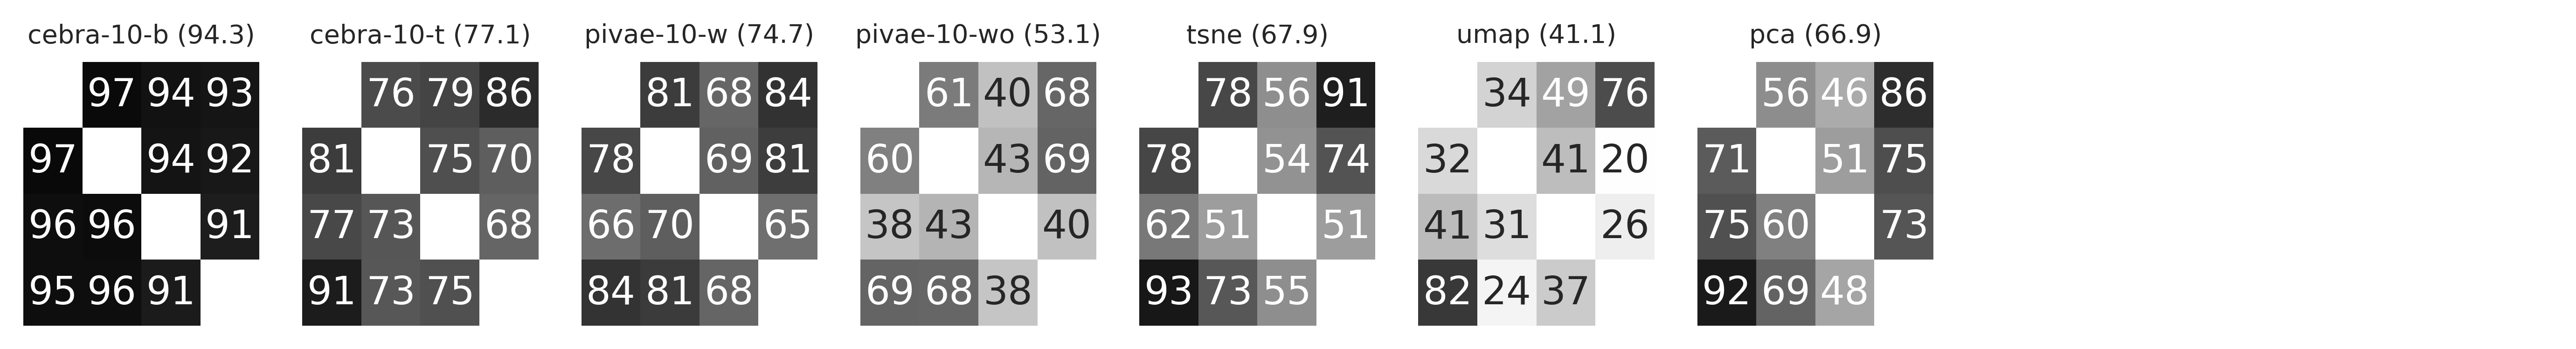

In [126]:
plt.rcParams['text.usetex'] = False

def to_cfm(values):
  values = np.concatenate(values)
  assert len(values) == 12, len(values)
  c = np.zeros((4,4))
  c[:] = float("nan")
  c[np.eye(4) == 0] = values
  return c

fig, axs = plt.subplots(ncols=10, nrows=1, figsize=(14, 1.5),
                        gridspec_kw={'width_ratios':[1,1,1,1,1,1,1,1,1,0.08]}, dpi = 500)

last_ax = axs[-1]

for ax in axs:
  ax.axis("off")

for ax, (key, log) in zip(axs[:-1], results_best.items()):
  cfm = log.pivot_table(
      "train",
      index = log.index.names,
      columns = ["animal"],
      aggfunc = "mean"
  ).apply(to_cfm, axis = 1)
  cfm, = cfm.values
  
  #display(log["train_run_consistency"])
  #print(cfm)
  #break
  #cfm = 100 * log.index(log.group_keys).loc[log.best_keys, "train_consistency"].apply(_to_matrix).mean()
  #print(pd.DataFrame(cfm).to_latex())
  #break
  
  sns.heatmap(
    data = np.minimum(cfm*100, 99),
    vmin = 20, vmax = 100,
    xticklabels = [],
    yticklabels = [],
    cmap = sns.color_palette('gray_r', as_cmap = True),
    annot = True, annot_kws={"fontsize": 12},
    cbar = True if (ax == axs[-2]) else False,
    cbar_ax = last_ax if (ax == axs[-2]) else None,
    ax = ax,
  )
  ax.set_title(f"{key} ({100*np.nanmean(cfm):.1f})", fontsize = 8)
  

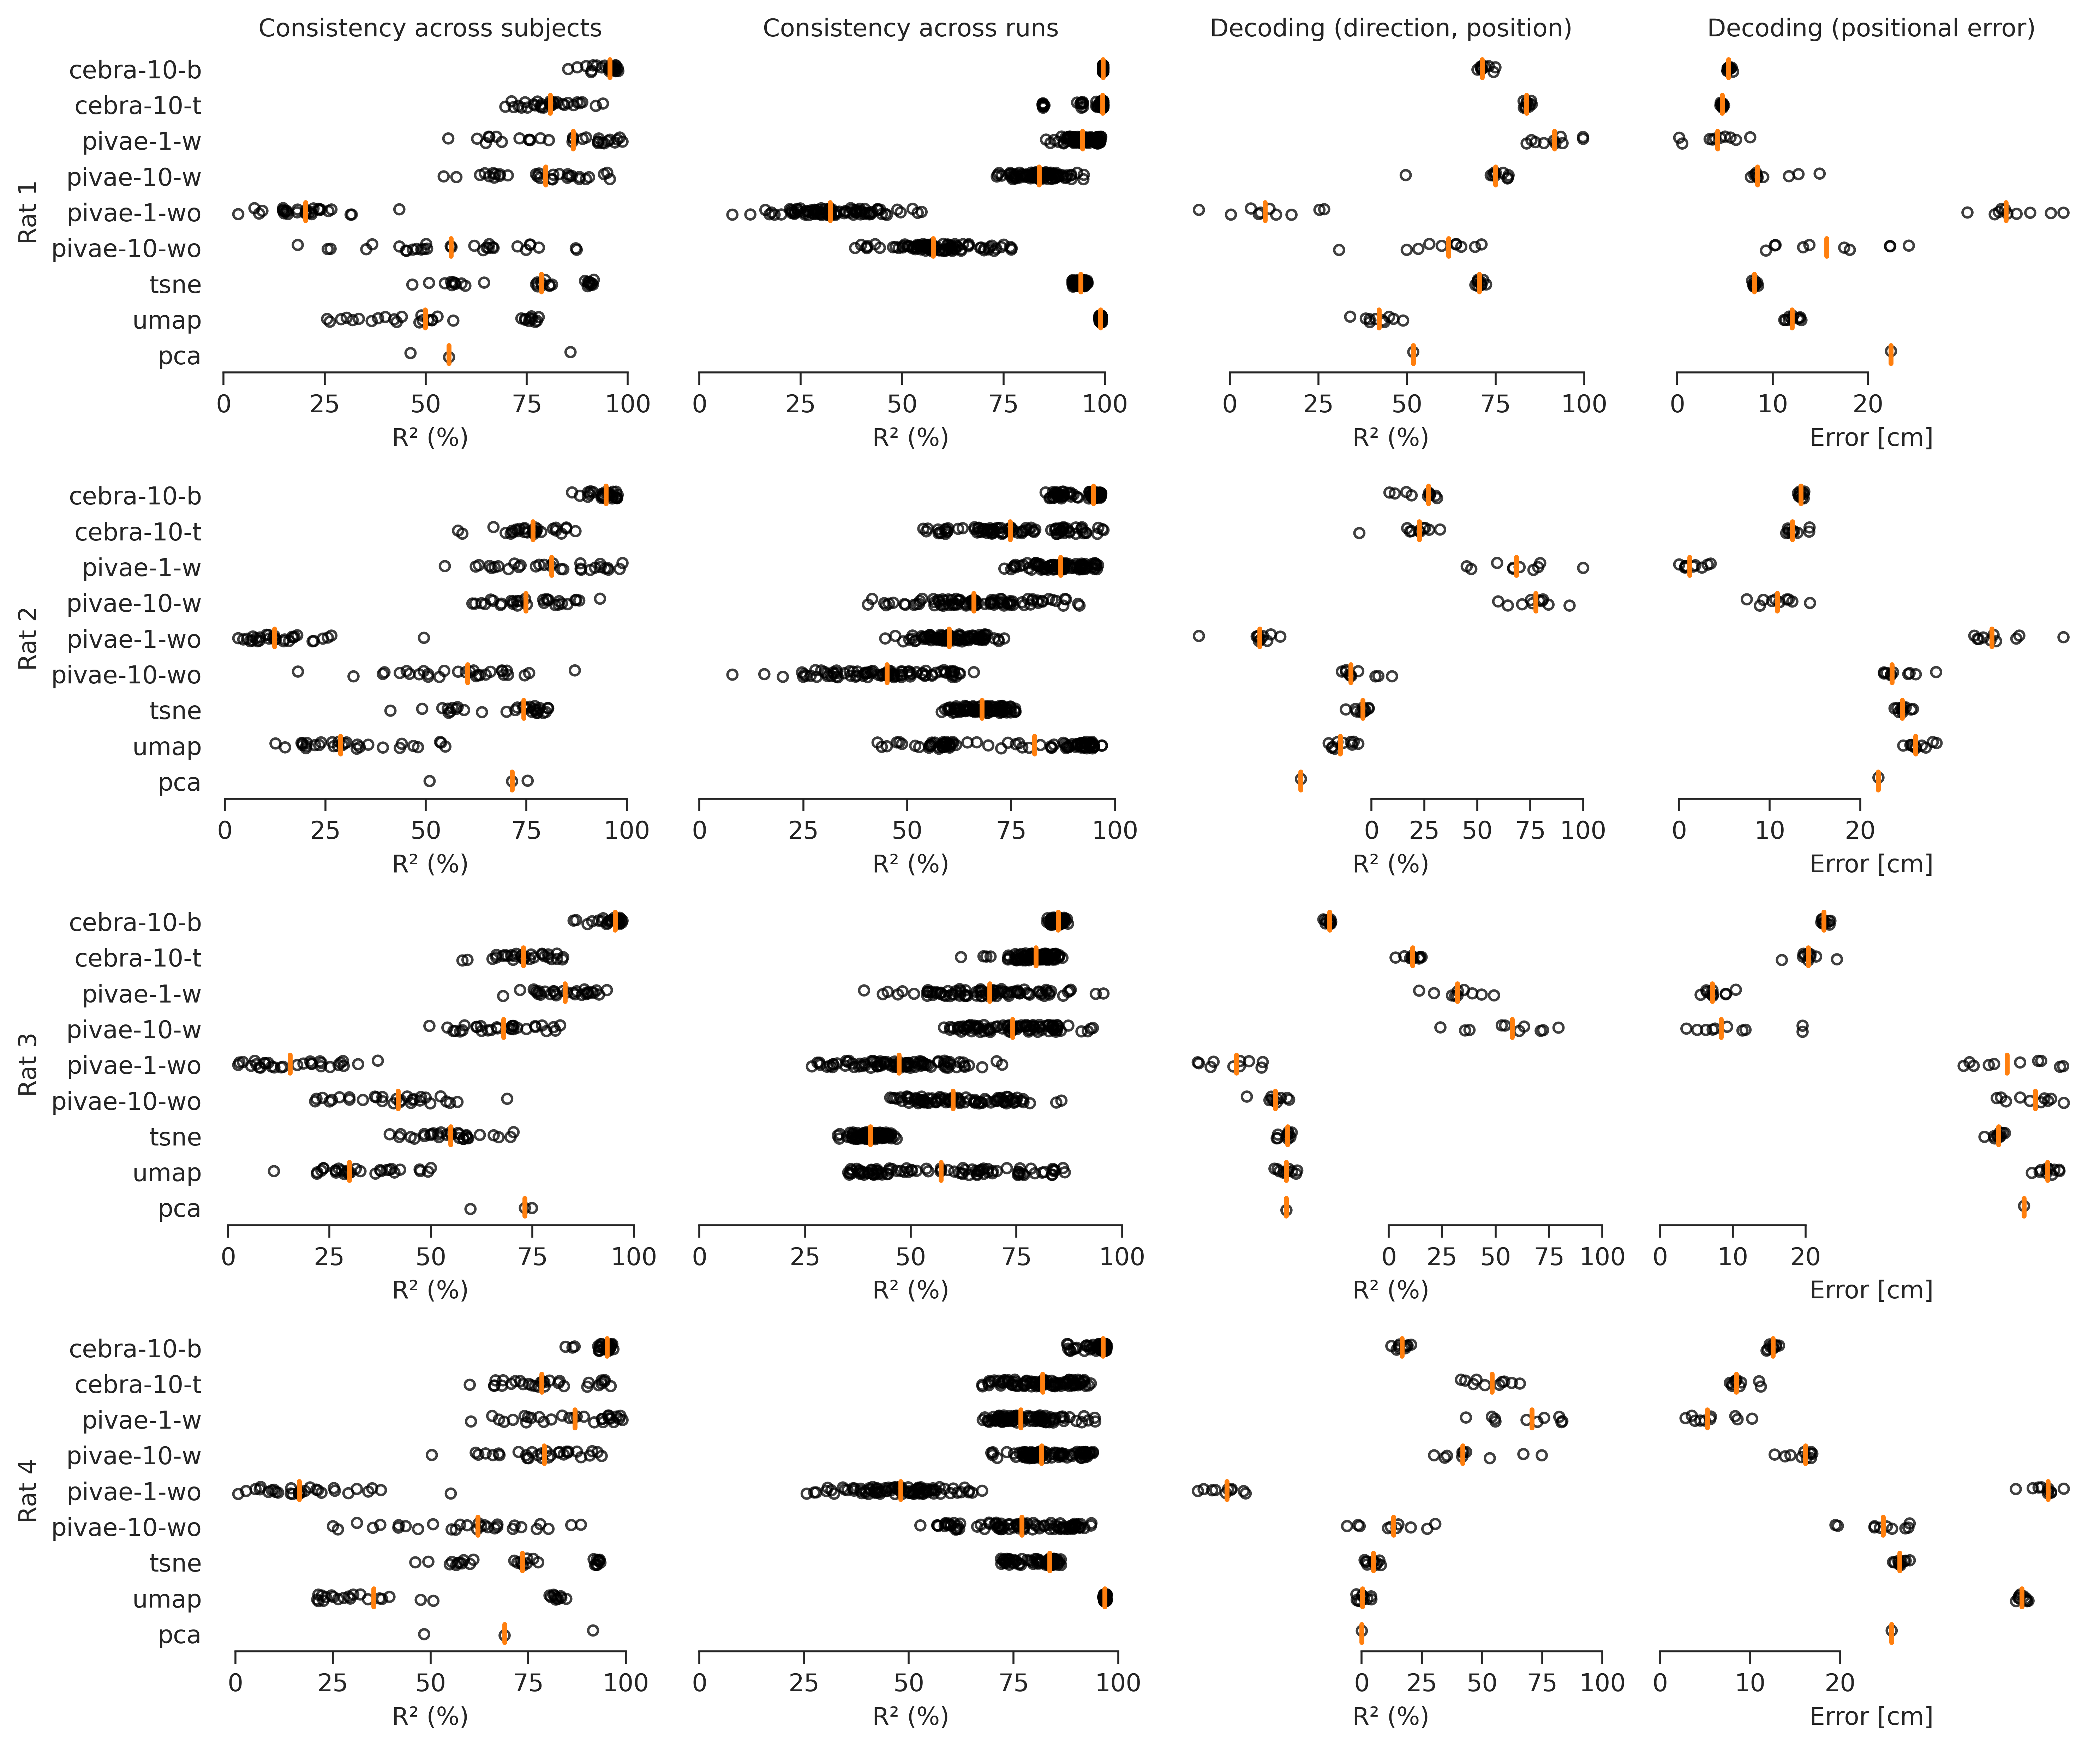

In [113]:
from matplotlib.markers import MarkerStyle
import warnings
import typing

def show_boxplot(df, metric, ax, labels = None):

  sns.set_style("white")
  
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    color = 'C1'
    sns.boxplot(
        data = df,
        y = 'method',
        x = metric,
        orient = 'h',
        order = labels, #unique(labels.values()),
        #hue = "rat",
        width = .5,
        color = 'k',
        linewidth = 2,
        flierprops = dict(alpha = .5, markersize = 0, marker = '.', linewidth = 0),
        medianprops = dict(c = 'C1', markersize = 0, marker = '.', linewidth = 2, solid_capstyle='round'),
        whiskerprops = dict(solid_capstyle='butt', linewidth = 0),
        #capprops = dict(c = 'C1', markersize = 0, marker = 'o', linewidth = 1),
        showbox=False, showcaps=False,
        #shownotches = True
        ax = ax,

    )
    marker_style = MarkerStyle("o", "none")
    
    sns.stripplot(
      data = df,
      y = 'method',
      x = metric,
      orient = 'h',
      size = 4,
      color = "black",
      order = labels,
      marker = marker_style,
      linewidth = 1,
      ax = ax,
      alpha = 0.75,
      jitter = 0.1,
      zorder = -1,
    )
    #sns.despine(left = True, ax = ax)
    #ax.get_legend().remove()
    ax.set_ylabel("")
    sns.despine(left = True, bottom = False, ax = ax)
    #ax.tick_params(axis = 'x', length = 2, colors = "black")
    ax.tick_params(
      axis='x',
      which='both',
      bottom=True,
      top=False,
      length = 5,
      labelbottom=True)
    return ax

def _add_value(df, **kwargs):
  for key, value in kwargs.items():
    df[key] = value
  return df

def join(results):
  return pd.concat([_add_value(df, method = key) for key, df in results.items()])

import seaborn as sns
import matplotlib.pyplot as plt

#idx = aggregated.sort_values("train", ascending = True).tail(1).set_index(group_keys).index
#best = df.set_index(group_keys).loc[idx]
#best = best.groupby(group_keys + ["seed"]).mean()
#best["train_consistency"] = best["train"]

metadata = [
  ("train", "Consistency across subjects", 100, "R² (%)", [0,25,50,75,100]),
  ("train_run_consistency", "Consistency across runs", 100, "R² (%)", [0,25,50,75,100]),
  ("test_total_r2", "Decoding (direction, position)", 100, "R² (%)", [0,25,50,75,100]),
  ("test_position_error", "Decoding (positional error)", 100, "Error [cm]", [0, 10, 20])
]

import itertools

results_ = join(results_best)
fig, axes = plt.subplots(4,4,figsize = (12, 10), dpi = 500, sharey = True)

label_order = tuple(results_best.keys())

def _agg(v):
  return sum(v) / len(v)

for metric_id, (metric, metric_name, scale, xlabel, xlim) in enumerate(metadata):
  #table = results_.reset_index(drop = True).groupby(["method", "animal", "seed"])[metric].agg(_agg).reset_index()
  #display(table)
  
  table = results_.reset_index(drop = True).pivot_table(
    metric,
    index = ["animal", "repeat"],
    columns = ["method"],
    aggfunc = list #lambda v : list(itertools.chain.from_iterable(v) if isinstance(v, list) else list(v))
  ).applymap(lambda v : list(itertools.chain.from_iterable(v) if isinstance(v[0], typing.Iterable) else v))\
  .groupby("animal", level = 0).agg(lambda v : np.stack(v).mean(0))
  #display(table.applymap(lambda a : a.shape))
  #display(table)
  #continue
  for animal in table.index:
    df = table.loc[animal].reset_index()
    df.columns = 'method', 'metric'
    df = df.explode("metric")
    df["metric"] *= scale
    
    #df = df[df.method.apply(lambda v : "cebra-t" in v)]

    show_boxplot(
      df = df,
      metric = "metric",
      ax = axes[animal, metric_id],
      labels = label_order
    )
    ax = axes[animal, metric_id]
    #sns.despine(ax = ax, trim = True, left = True)
    ax.set_xlabel(xlabel)
    ax.set_xticks(xlim)
    ax.spines['bottom'].set_bounds(min(xlim), max(xlim))
    
    axes[0, metric_id].set_title(metric_name, fontsize = 10)
    axes[animal, 0].set_ylabel(f"Rat {animal+1}")
    
plt.tight_layout() #w_pad = 0)

In [134]:
all_metrics = [
  'all_run_consistency',
  'train_run_consistency',
  'valid_run_consistency',
  'test_run_consistency',
  'all', 'train', 'valid', 'test', 'knn',
  'valid_total_r2', 'valid_position_error', 'valid_position_r2',
  'test_total_r2', 'test_position_error', 'test_position_r2'
]

def read_mcmc(fname):

  pivae_mcmc = pd.read_csv(fname, index_col = 0)

  columns = pivae_mcmc.columns
  metrics = ['test_total_r2', 'test_position_error', 'test_position_r2']
  meta = ["mouse", "seed", "repeat"]
  index = [c for c in columns if not (c in metrics or c in meta)]
  pivae_mcmc = pivae_mcmc.set_index(index)
  mice = sorted(pivae_mcmc["mouse"].unique())
  pivae_mcmc["animal"] = pivae_mcmc["mouse"].apply(mice.index)
  pivae_mcmc = pivae_mcmc.drop(columns = "mouse")
  for metric in all_metrics:
    if metric not in pivae_mcmc.columns:
      pivae_mcmc[metric] = float("nan")
  pivae_mcmc["method"] = "pivae-mcmc"
  
  return pivae_mcmc

if "pivae-mcmc" in results_best:
  del results_best["pivae-mcmc"]
for key in ["seed", "repeat", "animal"]:
  for k, v in results_best.items():
    results_best[k][key] = results_best[k][key].apply(int)

In [32]:
df = read_mcmc("pivae-mcmc.csv")
df[df.animal == 0].test_position_error.mean()

0.11124251210227956

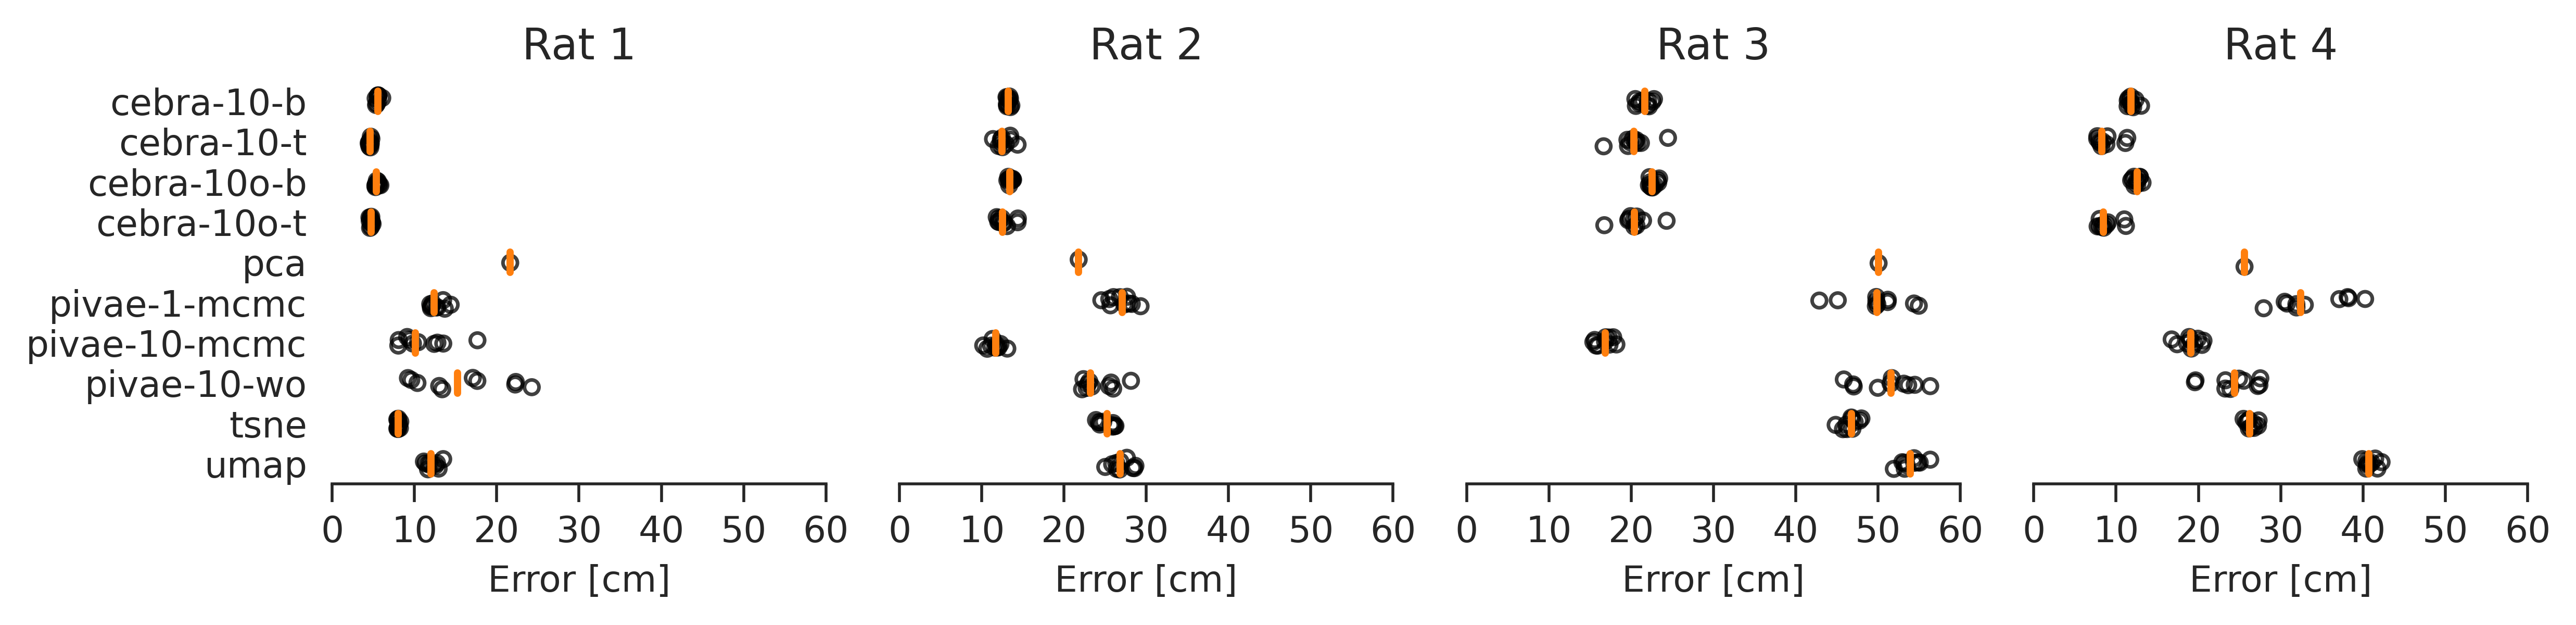

In [135]:
from matplotlib.markers import MarkerStyle
import warnings
import typing

def show_boxplot(df, metric, ax, labels = None, color = "C1"):

  sns.set_style("white")
  
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sns.boxplot(
        data = df,
        y = 'method',
        x = metric,
        orient = 'h',
        order = labels, #unique(labels.values()),
        #hue = "rat",
        width = .5,
        color = 'k',
        linewidth = 2,
        flierprops = dict(alpha = .5, markersize = 0, marker = '.', linewidth = 0),
        medianprops = dict(c = color, markersize = 0, marker = '.', linewidth = 2, solid_capstyle='round'),
        whiskerprops = dict(solid_capstyle='butt', linewidth = 0),
        #capprops = dict(c = 'C1', markersize = 0, marker = 'o', linewidth = 1),
        showbox=False, showcaps=False,
        #shownotches = True
        ax = ax,

    )
    marker_style = MarkerStyle("o", "none")
    
    sns.stripplot(
      data = df,
      y = 'method',
      x = metric,
      orient = 'h',
      size = 4,
      color = "black",
      order = labels,
      marker = marker_style,
      linewidth = 1,
      ax = ax,
      alpha = 0.75,
      jitter = 0.15,
      zorder = -1,
    )
    #sns.despine(left = True, ax = ax)
    #ax.get_legend().remove()
    ax.set_ylabel("")
    sns.despine(left = True, bottom = False, ax = ax)
    #ax.tick_params(axis = 'x', length = 2, colors = "black")
    ax.tick_params(
      axis='x',
      which='both',
      bottom=True,
      top=False,
      length = 5,
      labelbottom=True)
    return ax

def _add_value(df, **kwargs):
  for key, value in kwargs.items():
    df[key] = value
  return df

def join(results):
  return pd.concat([_add_value(df, method = key) for key, df in results.items()])

import seaborn as sns
import matplotlib.pyplot as plt

#idx = aggregated.sort_values("train", ascending = True).tail(1).set_index(group_keys).index
#best = df.set_index(group_keys).loc[idx]
#best = best.groupby(group_keys + ["seed"]).mean()
#best["train_consistency"] = best["train"]

metadata = [
  #("train", "Consistency across subjects", 100, "R² (%)", [0,25,50,75,100]),
  #("train_run_consistency", "Consistency across runs", 100, "R² (%)", [0,25,50,75,100]),
  #("test_total_r2", "Decoding (direction, position)", 100, "R² (%)", [-25,0,25,50,75,100]),
  ("test_position_error", "Decoding (positional error)", 100, "Error [cm]", [0, 10, 20, 30, 40, 50, 60]),
  #("test_position_error_svm", "Decoding (positional error)", 100, "Error [cm]", [0, 10, 20, 30, 40])
]

import itertools

results_best['pivae-1-mcmc'] = read_mcmc("pivae-step1-mcmc.csv")
results_best['pivae-10-mcmc'] = read_mcmc("pivae-mcmc.csv")

results_ = join(results_best)
fig, axes = plt.subplots(1, 4,figsize = (10, 2.5), dpi = 500, sharey = True, sharex = True)

#label_order = tuple(results_best.keys())

def _agg(v):
  return sum(v) / len(v)

for metric_id, (metric, metric_name, scale, xlabel, xlim) in enumerate(metadata):
  #table = results_.reset_index(drop = True).groupby(["method", "animal", "seed"])[metric].agg(_agg).reset_index()
  #display(table)
  
  table = results_.reset_index(drop = True).pivot_table(
    metric,
    index = ["animal", "repeat"],
    columns = ["method"],
    aggfunc = list #lambda v : list(itertools.chain.from_iterable(v) if isinstance(v, list) else list(v))
  ).applymap(lambda v : list(itertools.chain.from_iterable(v) if isinstance(v[0], typing.Iterable) else v))\
  .groupby("animal", level = 0).agg(lambda v : np.stack(v).mean(0))
  
  #.applymap(lambda v : v)\
  #.groupby("animal", level = 0).agg(lambda v : np.stack(v).mean(0))
  #display(table.applymap(lambda a : a.shape))
  #display(table)
  #continue
  #cebra32 = pd.read_pickle("figure4_decoding_results.pkl")
  #table = pd.concat([table, cebra32], axis = 1)
  #display(table)
  for animal in table.index:
    df = table.loc[animal].reset_index()
    df.columns = 'method', 'metric'
    df = df.explode("metric")
    df["metric"] *= scale
    #df = df[df.method.apply(lambda v : "-1-" in v)]
    #print(df.method.value_counts())
    
    #display(df)
    
    label_order = sorted(tuple(df.method.unique()))
    
    #df = df[df.method.apply(lambda v : "cebra-t" in v)]
    show_boxplot(
      df = df,
      metric = "metric",
      ax = axes[animal], #, metric_id],
      #labels = label_order,
      color = "C2" if ("svm" in metric) else "C1"
    )
    ax = axes[animal]
    #sns.despine(ax = ax, trim = True, left = True)
    ax.set_xlabel(xlabel)
    ax.set_xticks(xlim)
    ax.spines['bottom'].set_bounds(min(xlim), max(xlim))
    
    #axes[0, metric_id].set_title(metric_name, fontsize = 10)
    #axes[animal, 0].set_ylabel(f"Rat {animal+1}")
    
    #ax.set_yticklabels([
    #  "CEBRA-Behavior",
    #  "pi-VAE, MCMC",
    #  "CEBRA-Time",
    #  "pi-VAE, kNN",
    #  "t-SNE",
    #  "UMAP",
    #  "PCA"
    #])
    ax.set_ylabel("")
    ax.set_title(f"Rat {animal+1}")
    
plt.tight_layout()